# Pyspark TensorFlow Inference

## Text classification
Based on: https://www.tensorflow.org/tutorials/keras/text_classification

### Using TensorFlow
Note that cuFFT/cuDNN/cuBLAS registration errors are expected with `tf=2.17.0` and will not affect behavior, as noted in [this issue.](https://github.com/tensorflow/tensorflow/issues/62075)  
This notebook does not demonstrate inference with TensorRT, as [TF-TRT](https://docs.nvidia.com/deeplearning/tensorrt/release-notes/index.html#tensorrt-10) does not yet support `tf=2.17.0`. See the `pytorch` notebooks for TensorRT demos.

In [1]:
import os
import re
import shutil
import string

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, losses

2024-10-24 16:15:43.020721: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 16:15:43.028070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 16:15:43.035674: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 16:15:43.037910: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 16:15:43.044256: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)

2.17.0


In [3]:
# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [10]:
import pathlib
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(
    fname="aclImdb", origin=url, untar=True,
)

dataset_dir = pathlib.Path(dataset)

In [11]:
print(dataset_dir)
# aclImdb might be created as a directory containing a single directory aclImdb. Check if this is the case:
if os.path.exists(dataset_dir / "aclImdb"):
    dataset_dir = dataset_dir / "aclImdb"
print(dataset_dir)

/home/rishic/.keras/datasets/aclImdb
/home/rishic/.keras/datasets/aclImdb


In [6]:
os.listdir(dataset_dir)

['README', 'imdb.vocab', 'test', 'train', 'imdbEr.txt']

In [13]:
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")
os.listdir(train_dir)

['pos',
 'labeledBow.feat',
 'urls_pos.txt',
 'neg',
 'urls_unsup.txt',
 'unsupBow.feat',
 'urls_neg.txt',
 'unsup']

In [14]:
sample_file = os.path.join(train_dir, "pos/1181_9.txt")
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [15]:
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [17]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2024-10-24 02:18:45.343343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46446 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

2024-10-03 17:44:08.132892: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [13]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [15]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2024-10-03 17:44:10.225130: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


I0000 00:00:1727977450.773487 1857915 service.cc:146] XLA service 0xac47fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727977450.773523 1857915 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-10-03 17:44:10.785495: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-03 17:44:10.838694: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 88/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5075 - loss: 0.6925  

I0000 00:00:1727977451.426198 1857915 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.5797 - loss: 0.6821 - val_binary_accuracy: 0.7248 - val_loss: 0.6141
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - binary_accuracy: 0.7588 - loss: 0.5810 - val_binary_accuracy: 0.8092 - val_loss: 0.4989
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - binary_accuracy: 0.8197 - loss: 0.4674 - val_binary_accuracy: 0.8282 - val_loss: 0.4282
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - binary_accuracy: 0.8514 - loss: 0.3946 - val_binary_accuracy: 0.8402 - val_loss: 0.3870
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - binary_accuracy: 0.8673 - loss: 0.3488 - val_binary_accuracy: 0.8494 - val_loss: 0.3608
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - binary_accuracy: 0.8809 - loss: 0.3174 - val_binary_accuracy: 0.8498 - val_loss: 0.3477
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - binary_accuracy: 0.8899 - loss: 0.2913 - val_binary_accuracy: 0.8554 - val_loss: 0.3325
Epoch

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

  1/782 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - binary_accuracy: 0.9062 - loss: 0.2768

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - binary_accuracy: 0.8542 - loss: 0.3343
Loss:  0.33130890130996704
Accuracy:  0.856440007686615


In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

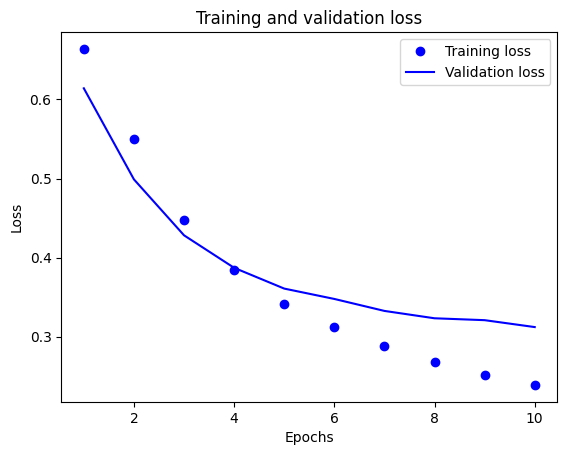

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

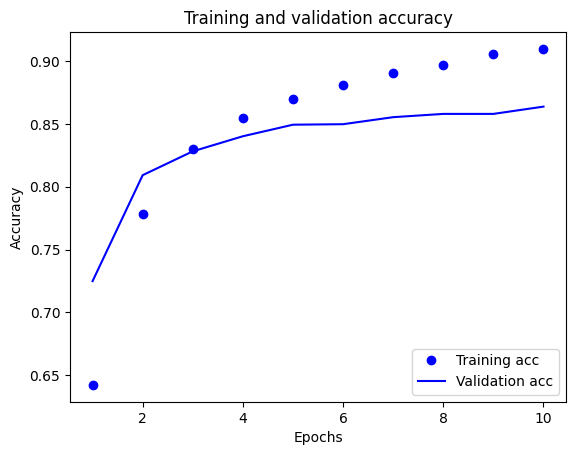

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4993 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00
{'accuracy': 0.5000399947166443, 'binary_accuracy': 0.0, 'loss': 0.0}


In [32]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


array([[0.5858644 ],
       [0.5499682 ],
       [0.53613865]], dtype=float32)

### Save Model

In [33]:
!rm -rf text_model

In [34]:
export_model.save('text_model.keras')

### Load model

In [35]:
# register callables as custom objects before loading
custom_objects = {"vectorize_layer": vectorize_layer, "custom_standardization": custom_standardization}
with tf.keras.utils.custom_object_scope(custom_objects):
    new_model = tf.keras.models.load_model('text_model.keras', compile=False)

new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 250)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 1)              │       160,017 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,017 (625.07 KB)

 Trainable params: 160,017 (625.07 KB)

 Non-trainable params: 0 (0.00 B)

### Predict

In [36]:
new_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


array([[0.5858644 ],
       [0.5499682 ],
       [0.53613865]], dtype=float32)

## PySpark

## Inference using Spark DL API
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [37]:
import os
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col
from pyspark.sql.types import ArrayType, FloatType, DoubleType
from pyspark.sql import SparkSession
from pyspark import SparkConf

In [ ]:
import os
conda_env = os.environ.get("CONDA_PREFIX")

conf = SparkConf()
if 'spark' not in globals():
    # If Spark is not already started with Jupyter, attach to Spark Standalone
    import socket
    hostname = socket.gethostname()
    conf.setMaster(f"spark://{hostname}:7077") # assuming Master is on default port 7077
conf.set("spark.task.maxFailures", "1")
conf.set("spark.driver.memory", "8g")
conf.set("spark.executor.memory", "8g")
conf.set("spark.pyspark.python", f"{conda_env}/bin/python")
conf.set("spark.pyspark.driver.python", f"{conda_env}/bin/python")
conf.set("spark.sql.execution.pyspark.udf.simplifiedTraceback.enabled", "false")
conf.set("spark.sql.pyspark.jvmStacktrace.enabled", "true")
conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
conf.set("spark.python.worker.reuse", "true")
# Create Spark Session
spark = SparkSession.builder.appName("spark-dl-examples").config(conf=conf).getOrCreate()
sc = spark.sparkContext

In [39]:
from datasets import load_dataset

# load IMDB reviews (test) dataset
data = load_dataset("imdb", split="test")
lines = []
for example in data:
    lines.append([example["text"].split(".")[0]])
    
df = spark.createDataFrame(lines, ['lines']).repartition(8)

In [40]:
text_model_path = "{}/text_model.keras".format(os.getcwd())

In [41]:
def predict_batch_fn():
    # since this function runs on the executor, any required imports should be added inside the function.
    import re
    import string
    import tensorflow as tf
    from tensorflow.keras import layers

    # Enable GPU memory growth to avoid CUDA OOM
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    def custom_standardization(input_data):
        lowercase = tf.strings.lower(input_data)
        stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
        return tf.strings.regex_replace(
            stripped_html, "[%s]" % re.escape(string.punctuation), ""
        )

    max_features = 10000
    sequence_length = 250

    vectorize_layer = layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode="int",
        output_sequence_length=sequence_length,
    )

    custom_objects = {"vectorize_layer": vectorize_layer,
                      "custom_standardization": custom_standardization}
    with tf.keras.utils.custom_object_scope(custom_objects):
        model = tf.keras.models.load_model(text_model_path)

    def predict(inputs):
        return model.predict(inputs)

    return predict

In [42]:
classify = predict_batch_udf(predict_batch_fn,
                             return_type=FloatType(),
                             batch_size=256)

In [43]:
%%time
predictions = df.withColumn("preds", classify(struct("lines")))
results = predictions.collect()

CPU times: user 22.3 ms, sys: 6.39 ms, total: 28.7 ms
Wall time: 5.95 s


In [44]:
%%time
predictions = df.withColumn("preds", classify("lines"))
results = predictions.collect()

CPU times: user 98.3 ms, sys: 8.08 ms, total: 106 ms
Wall time: 1.24 s


In [45]:
%%time
predictions = df.withColumn("preds", classify(col("lines")))
results = predictions.collect()

CPU times: user 16.1 ms, sys: 4.41 ms, total: 20.6 ms
Wall time: 1.18 s


In [46]:
predictions.show(truncate=80)

+--------------------------------------------------------------------------------+----------+
|                                                                           lines|     preds|
+--------------------------------------------------------------------------------+----------+
|i do not understand at all why this movie received such good grades from crit...| 0.5006337|
|                              I am a big fan of The ABC Movies of the Week genre|0.57577586|
|                         Strangeland is a terrible horror/technological thriller| 0.5441176|
|Sex,Drugs,Rock & Roll is without a doubt the worst product of Western Civiliz...|0.53261155|
|                                Not to be mistaken as the highly touted Samuel L| 0.5785005|
|Following the pleasingly atmospheric original and the amusingly silly second ...|0.51597977|
|                                   No idea how this is rated as high as it is (5|0.55052567|
|When I saw this in the cinema, I remember wincing at the ba

### Using Triton Inference Server

Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

This notebook uses the [Python backend with a custom execution environment](https://github.com/triton-inference-server/python_backend#creating-custom-execution-environments) for Triton 24.08, using a conda-pack environment created as follows:
```
conda create -n tf-gpu -c conda-forge python=3.10.0
conda activate tf-gpu

export PYTHONNOUSERSITE=True
pip install numpy==1.26.4 tensorflow[and-cuda] conda-pack

conda pack  # tf-gpu.tar.gz
```

In [47]:
import numpy as np
import os
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import col, struct
from pyspark.sql.types import ArrayType, FloatType

In [48]:
%%bash
# copy custom model to expected layout for Triton
rm -rf models
mkdir -p models
cp -r models_config/text_classification models

# add custom execution environment
cp tf-gpu.tar.gz models

In [49]:
import unicodedata

def normalize_vocabulary(vocab):
    # Normalize each word in the vocabulary to remove non-ASCII characters
    normalized_vocab = [
        unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8')
        for word in vocab
    ]
    normalized_vocab = filter(lambda x: x != '', normalized_vocab)
    normalized_vocab = list(set(normalized_vocab)) 


    return normalized_vocab

vocab = vectorize_layer.get_vocabulary()
normalized_vocab = normalize_vocabulary(vocab)

# Reassign the cleaned vocabulary to the TextVectorization layer
vectorize_layer.set_vocabulary(normalized_vocab)

# Save the model with the cleaned vocabulary
export_model.save('text_model_cleaned.keras')

#### Start Triton Server on each executor

In [50]:
num_executors = 1
triton_models_dir = "{}/models".format(os.getcwd())
text_model_dir = "{}/text_model_cleaned.keras".format(os.getcwd())
nodeRDD = sc.parallelize(list(range(num_executors)), num_executors)

def start_triton(it):
    import docker
    import time
    import tritonclient.grpc as grpcclient
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    if containers:
        print(">>>> containers: {}".format([c.short_id for c in containers]))
    else:
        container=client.containers.run(
            "nvcr.io/nvidia/tritonserver:24.08-py3", "tritonserver --model-repository=/models",
            detach=True,
            device_requests=[docker.types.DeviceRequest(device_ids=["0"], capabilities=[['gpu']])],
            name="spark-triton",
            network_mode="host",
            remove=True,
            shm_size="128M",
            volumes={
                triton_models_dir: {"bind": "/models", "mode": "ro"},
                text_model_dir: {"bind": "/text_model_cleaned.keras", "mode": "ro"}
            }
        )
        print(">>>> starting triton: {}".format(container.short_id))

        # wait for triton to be running
        time.sleep(15)
        client = grpcclient.InferenceServerClient("localhost:8001")
        ready = False
        while not ready:
            try:
                ready = client.is_server_ready()
            except Exception as e:
                time.sleep(5)
            
    return [True]

nodeRDD.barrier().mapPartitions(start_triton).collect()

[True]

#### Run inference

In [51]:
from datasets import load_dataset

# load IMDB reviews (test) dataset
data = load_dataset("imdb", split="test")
lines = []
for example in data:
    lines.append([example["text"].split(".")[0]])

df = spark.createDataFrame(lines, ['lines']).repartition(10)
df.show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                               lines|
+----------------------------------------------------------------------------------------------------+
|i do not understand at all why this movie received such good grades from critics - - i've seen te...|
|                                                  I am a big fan of The ABC Movies of the Week genre|
|                                             Strangeland is a terrible horror/technological thriller|
|                  Sex,Drugs,Rock & Roll is without a doubt the worst product of Western Civilization|
|                                                    Not to be mistaken as the highly touted Samuel L|
|Following the pleasingly atmospheric original and the amusingly silly second one, this incredibly...|
|                                                       No idea how this 

In [52]:
columns = df.columns
columns

['lines']

In [53]:
def triton_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient
    
    np_types = {
      "BOOL": np.dtype(np.bool_),
      "INT8": np.dtype(np.int8),
      "INT16": np.dtype(np.int16),
      "INT32": np.dtype(np.int32),
      "INT64": np.dtype(np.int64),
      "FP16": np.dtype(np.float16),
      "FP32": np.dtype(np.float32),
      "FP64": np.dtype(np.float64),
      "FP64": np.dtype(np.double),
      "BYTES": np.dtype(object)
    }

    client = grpcclient.InferenceServerClient(triton_uri)
    model_meta = client.get_model_metadata(model_name)
    
    def predict(inputs):
        if isinstance(inputs, np.ndarray):
            # single ndarray input
            request = [grpcclient.InferInput(model_meta.inputs[0].name, inputs.shape, model_meta.inputs[0].datatype)]
            request[0].set_data_from_numpy(inputs.astype(np_types[model_meta.inputs[0].datatype]))
        else:
            # dict of multiple ndarray inputs
            request = [grpcclient.InferInput(i.name, inputs[i.name].shape, i.datatype) for i in model_meta.inputs]
            for i in request:
                i.set_data_from_numpy(inputs[i.name()].astype(np_types[i.datatype()]))
        
        response = client.infer(model_name, inputs=request)
        
        if len(model_meta.outputs) > 1:
            # return dictionary of numpy arrays
            return {o.name: response.as_numpy(o.name) for o in model_meta.outputs}
        else:
            # return single numpy array
            return response.as_numpy(model_meta.outputs[0].name)
        
    return predict

In [54]:
from functools import partial

classify = predict_batch_udf(partial(triton_fn, triton_uri="localhost:8001", model_name="text_classification"),
                             input_tensor_shapes=[[1]],
                             return_type=FloatType(),
                             batch_size=2048)

In [55]:
%%time
df.withColumn("preds", classify(struct(*columns))).show(truncate=80)

+--------------------------------------------------------------------------------+----------+
|                                                                           lines|     preds|
+--------------------------------------------------------------------------------+----------+
|i do not understand at all why this movie received such good grades from crit...| 0.5380144|
|                              I am a big fan of The ABC Movies of the Week genre|0.59806347|
|                         Strangeland is a terrible horror/technological thriller|0.54900867|
|Sex,Drugs,Rock & Roll is without a doubt the worst product of Western Civiliz...|0.56048334|
|                                Not to be mistaken as the highly touted Samuel L|0.56276447|
|Following the pleasingly atmospheric original and the amusingly silly second ...| 0.5571853|
|                                   No idea how this is rated as high as it is (5| 0.5637812|
|When I saw this in the cinema, I remember wincing at the ba

In [56]:
%%time
df.withColumn("preds", classify(*columns)).show(truncate=80)

+--------------------------------------------------------------------------------+----------+
|                                                                           lines|     preds|
+--------------------------------------------------------------------------------+----------+
|i do not understand at all why this movie received such good grades from crit...| 0.5380144|
|                              I am a big fan of The ABC Movies of the Week genre|0.59806347|
|                         Strangeland is a terrible horror/technological thriller|0.54900867|
|Sex,Drugs,Rock & Roll is without a doubt the worst product of Western Civiliz...|0.56048334|
|                                Not to be mistaken as the highly touted Samuel L|0.56276447|
|Following the pleasingly atmospheric original and the amusingly silly second ...| 0.5571853|
|                                   No idea how this is rated as high as it is (5| 0.5637812|
|When I saw this in the cinema, I remember wincing at the ba

#### Stop Triton Server on each executor

In [57]:
def stop_triton(it):
    import docker
    import time
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    print(">>>> stopping containers: {}".format([c.short_id for c in containers]))
    if containers:
        container=containers[0]
        container.stop(timeout=120)

    return [True]

nodeRDD.barrier().mapPartitions(stop_triton).collect()

[True]

In [58]:
spark.stop()